# Data Analysis Interview Challenge

This is your chance to wow us with creative and rigorous solutions! Please include your code at
the end of your submission, or in a separate file. We also accept incomplete solutions.

## Part 1 - Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn import metrics

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)


In [2]:
logins = pd.read_json('logins.json').set_index('login_time')
logins['login'] = 1
logins = logins.resample('15Min').count()
logins.head()

,login
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [3]:
print('Data range: {}'.format(logins.index[-1] - logins.index[0]))

Data range: 101 days 22:45:00


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
login    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


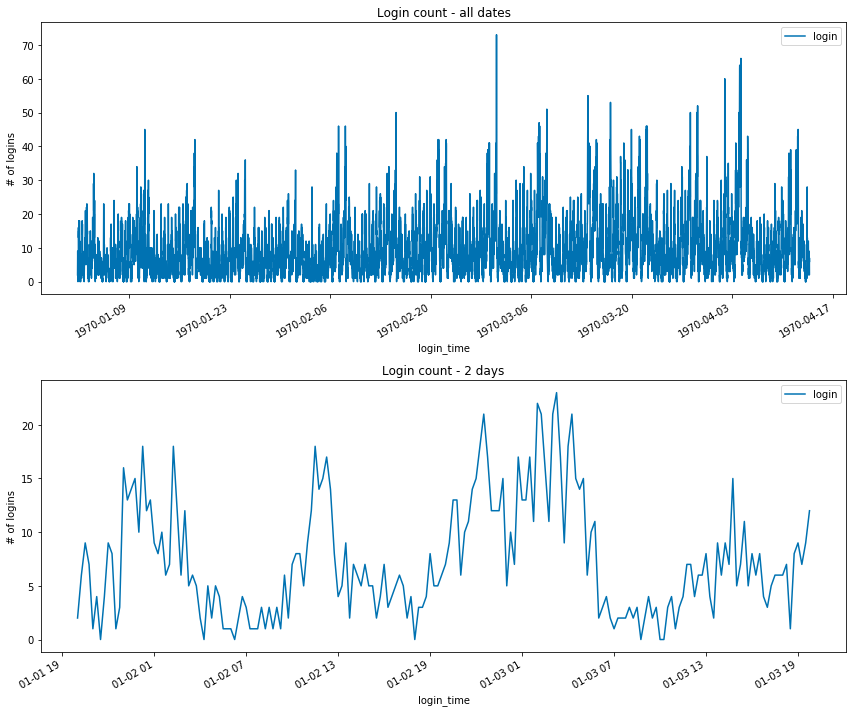

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,10))
logins.plot(x_compat=True, ax=ax1)
ax1.set_ylabel('# of logins')
ax1.set_title('Login count - all dates')
logins[:192].plot(x_compat=True, ax=ax2)
ax2.set_ylabel('# of logins')
ax2.set_title('Login count - 2 days')
plt.tight_layout()
plt.show()


The plot above shows a strong weekly cycle, a daily cycle, and a weak seasonal cycle. Additionally there are a few periods of unusually high demand, e.g.:

In [6]:
logins['login'].idxmax()

Timestamp('1970-03-01 04:30:00', freq='15T')

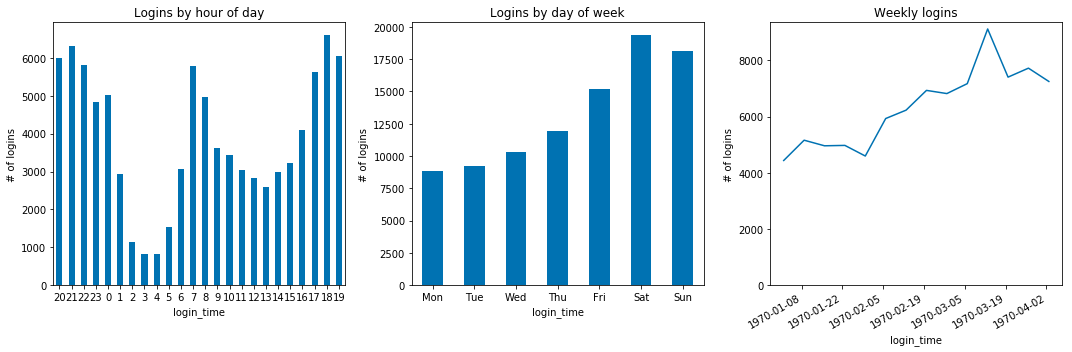

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
# hour of day
logins.groupby(logins.index.hour).sum().plot.bar(ax=ax1, rot=0, legend=False)
ax1.set_ylabel('# of logins')
ax1.set_title('Logins by hour of day')
ax1.set_ylim(ymin=0)
ax1.set_xticklabels([20, 21, 22, 23, 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

# day of week
logins.groupby(logins.index.dayofweek).sum().plot.bar(ax=ax2, rot=0, legend=False)
ax2.set_ylabel('# of logins')
ax2.set_ylim(ymin=0)
ax2.set_title('Logins by day of week')
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# weekly by month
logins.resample('7D').sum()[:-1].plot(x_compat=True, ax=ax3, legend=False) # ignore incomplete week
ax3.set_ylabel('# of logins')
ax3.set_title('Weekly logins')
ax3.set_ylim(ymin=0)


plt.tight_layout()
plt.show()


The time of day plot shows most of the activity in the morning (~6-10 am) and evening hours (~ 4-10 pm) with activity drops in the afternoon and early morning hours. This is consistent with regular rush hour commuting times.

Logins by day of week show increased weekend activity and the weekly trend shows steadily increasing activity with a surge in early March.

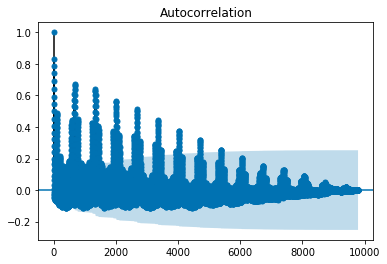

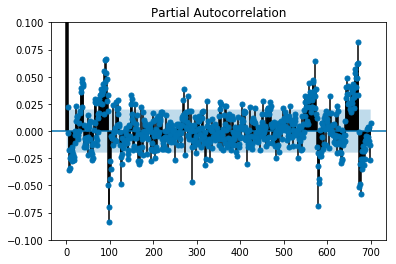

In [8]:
plot_acf(logins.login)
plt.show()
plot_pacf(logins.login, lags=700)
plt.ylim(-0.1, 0.1)
plt.show()

The partial autocorrelation above shows pronounced stickiness at lag 1 and significant periodicity at lag 96 (1 day), 576 (6 days) and 672 (7 days). Extending the plots by resampling to daily (below) there is no monthly lag and weekly lag is the dominant period.

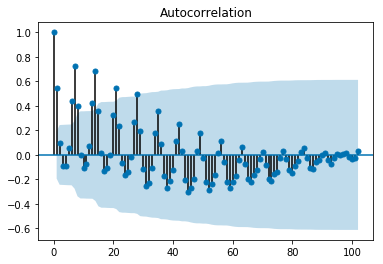

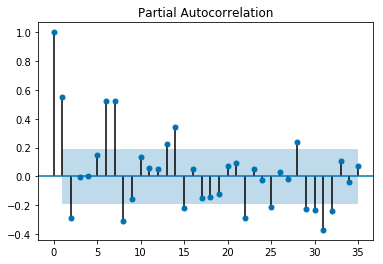

In [9]:
daily = logins.resample('D').sum()
plot_acf(daily.login)
plt.show()
plot_pacf(daily.login, lags=35)
plt.show()

# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 

Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### My response:

The underlying problem that is the basis for this experiment hasn't been made clear. Is Ultimate trying to increase revenue? Are city officials demanding better service? Is the number of drivers fixed? Are drivers unhappy with cyclical business? Is driver retention the reason there are not enough drivers? Why does surge pricing have no impact?

Taken at face value, the main metric would be reimbursed toll bridge crossings, assuming trips with passengers would include the bridge toll in the fare. If revenue is the driving force and surge pricing isn't a factor, then the combination of trip numbers and trip lengths that the revenue model is based on would be more appropriate.

There should be plenty of data available for metrics before toll reimbursement. This data could then be compared to the same metrics after reimbursing tolls for a defined amount of time. Any trends or seasonality would need to be removed and then hypothesis testing (e.g. t-test) would help determine if the metrics with and without toll reimbursement are different.

I would be careful to interpret the results without considering other factors that may impact driver behavior. An in-depth conversation with the stakeholders might reveal other ways to increase the metric. A design of experiment for multiple factors might be a better approach.

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long-term rider retention (again, a few sentences will suffice).

### Data description
● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [10]:
with open('ultimate_data_challenge.json', 'r') as f:
        datastore = json.load(f)
ultimate = pd.DataFrame(datastore)
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
ultimate.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [12]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
# convert dates to datetime format
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])

In [14]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# assign "active" to users who have booked trips in last 30 days
last_date = ultimate.last_trip_date.sort_values(ascending=False)[:1]
cutoff = last_date - timedelta(days=30)

ultimate['active'] = ultimate.apply(lambda x: True if x.last_trip_date > cutoff.values[0] else False, axis=1)

ultimate.groupby('active')['active'].agg('count')

active
False    31690
True     18310
Name: active, dtype: int64

In [16]:
active_user_pct = len(ultimate[ultimate.active]) / ultimate.shape[0]
print('{:.1f}% of users who signed up in January are still active.'.format(active_user_pct * 100))

36.6% of users who signed up in January are still active.


### Missing values

There are missing values for driver ratings and phone type. 

What is the breakdown of phone type?

In [17]:
ultimate.groupby('phone')['phone'].count()

phone
Android    15022
iPhone     34582
Name: phone, dtype: int64

In [18]:
ultimate.groupby('phone').mean()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
phone,,,,,,,,,
Android,5.978743,4.784144,4.627394,1.071718,8.540401,1.934962,0.320996,60.403202,0.195846
iPhone,5.701441,4.775132,4.590783,1.076412,9.020797,2.425944,0.398762,61.092612,0.440634


Approximately two-thirds of customers use an iphone and they are twice as likely to be active. Nonetheless, considering the small number of missing entries it would be better to drop the missing observations rather than fill it with imputed values.

In [19]:
ultimate = ultimate.dropna(subset=['phone'])
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49406 non-null float64
avg_rating_of_driver      41578 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
active                    49604 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


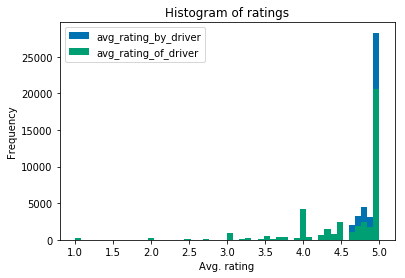

In [20]:
ultimate.loc[:,['avg_rating_by_driver', 'avg_rating_of_driver']].plot.hist(bins=50)
plt.title('Histogram of ratings')
plt.xlabel('Avg. rating')
plt.show()

In the case of avergage ratings, it appears safe to fill missing ratings with the respective medians since the vast majority of ratings are 5 and using the median will de-emphasize the low ratings.

In [21]:
# fill missing ratings with average values
ultimate = ultimate.fillna(ultimate.median())
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
active                    49604 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


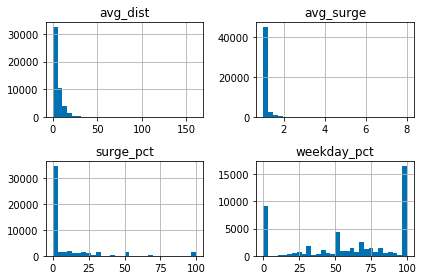

In [22]:
# Histograms of continuous variables ("float64")
ultimate[['avg_dist', 'avg_surge', 'surge_pct', 'weekday_pct']].hist(bins=30)

plt.tight_layout()
plt.show()

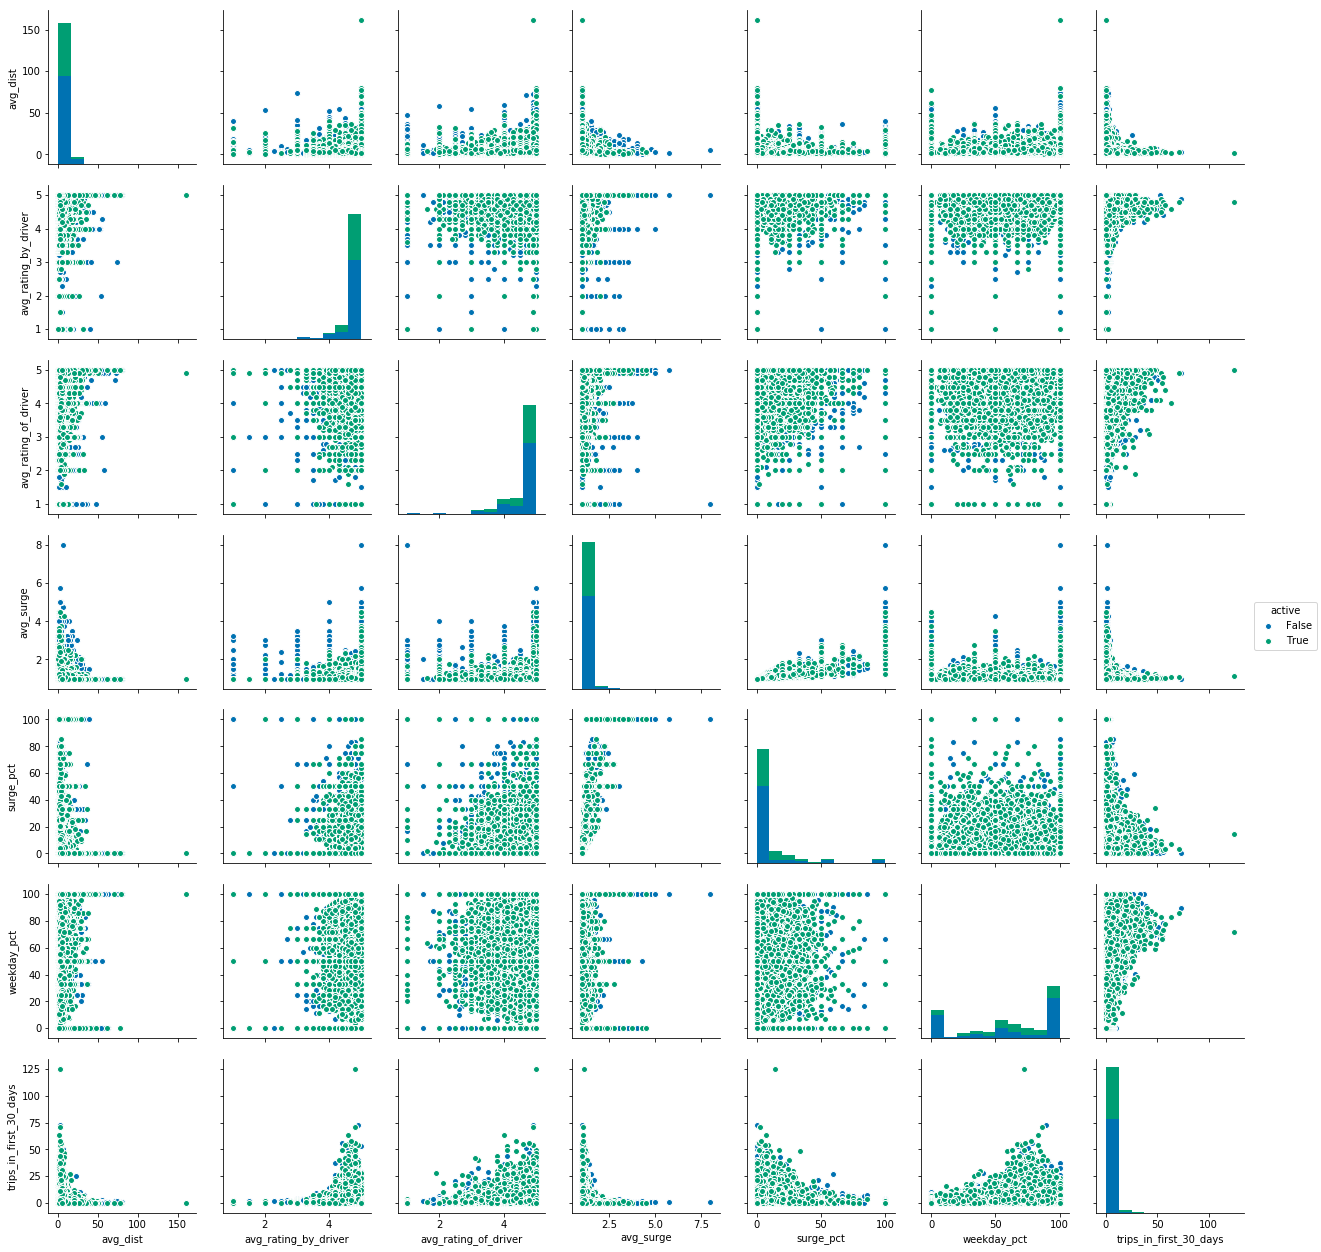

In [23]:
sns.pairplot(data=ultimate, hue='active', vars=['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'trips_in_first_30_days'])

Low driver or passenger ratings tend to reduce retention.

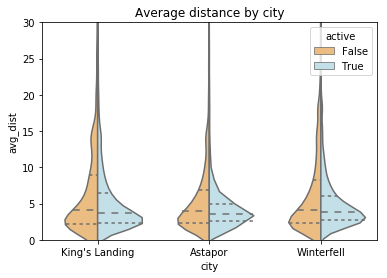

In [24]:
sns.violinplot(x='city', y='avg_dist', hue='active', data=ultimate, split=True, inner='quartile', palette='RdYlBu')
plt.title('Average distance by city')
plt.ylim(0,30)
plt.show()

Average distances greater than 10 miles are more likely for inactive users.

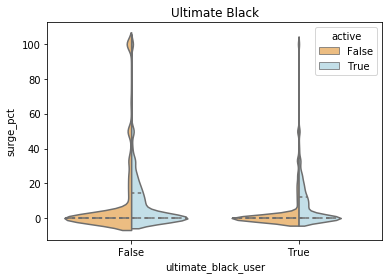

In [25]:
sns.violinplot(x='ultimate_black_user', y='surge_pct', hue='active', data=ultimate, split=True, inner='quartile', palette='RdYlBu')
plt.title('Ultimate Black')
plt.show()

Surge prices greater than 40% cause user attrition, except in ultimate black users.

In [26]:
surge = ultimate[ultimate.surge_pct > 40]
pd.crosstab(surge.ultimate_black_user, surge.active, margins=True)

active,False,True,All
ultimate_black_user,,,
False,2246,483,2729
True,264,236,500
All,2510,719,3229


In [27]:
dist = ultimate[ultimate.avg_dist > 10]
pd.crosstab(dist.ultimate_black_user, dist.active, margins=True)

active,False,True,All
ultimate_black_user,,,
False,3719,769,4488
True,1950,1047,2997
All,5669,1816,7485


# Prediction model

Given that we only have 6 months of data and signups from 1 month, this cannot be considered a time series problem. Either a regression classifier or a decision tree would be a good choice.

In [28]:
# prepare categorical features

features = ultimate.drop(['last_trip_date', 'signup_date', 'active'], axis=1) # dates not useful due to short range
X = pd.get_dummies(features, drop_first=True)
y = ultimate.active

# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
# Classifier model
clf = LogisticRegression(random_state=26)

steps = [('scaler', RobustScaler()), ('clf', clf)]
pipeline = Pipeline(steps)

param_grid = {'clf__C': [0.001,0.01,0.1,1,10,100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)

print("Grid scores on training set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# metrics:
print('Test set score: {:.2f}'.format(grid.best_score_))
pred = grid.predict(X_test)
print('roc_auc score: {:.2f}'.format(metrics.roc_auc_score(y_test, pred)))
print('Confusion Matrix')
cm = pd.DataFrame(metrics.confusion_matrix(y_test, pred))
cm    

Best parameters: {'clf__C': 0.1}
Grid scores on training set:
0.757 (+/-0.008) for {'clf__C': 0.001}
0.770 (+/-0.011) for {'clf__C': 0.01}
0.771 (+/-0.011) for {'clf__C': 0.1}
0.771 (+/-0.011) for {'clf__C': 1}
0.771 (+/-0.011) for {'clf__C': 10}
0.771 (+/-0.011) for {'clf__C': 100}
Test set score: 0.77
roc_auc score: 0.67
Confusion Matrix


,0,1
0,6733,1136
1,2297,2235


In [50]:
# The coefficients
classifier = grid.best_estimator_.named_steps['clf']
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': classifier.coef_[0]})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,avg_dist,-0.163531
1,avg_rating_by_driver,-0.046113
2,avg_rating_of_driver,-0.062292
3,avg_surge,-0.010086
4,surge_pct,0.032563
5,trips_in_first_30_days,0.365100
6,ultimate_black_user,0.911544
7,weekday_pct,0.070241
8,city_King's Landing,1.734882
9,city_Winterfell,0.533233


In [30]:
# Classifier model support vector classifier
clf = SVC()

steps = [('scaler', RobustScaler()), ('clf', clf)]
pipeline = Pipeline(steps)

param_grid = {'clf__C': [0.01, 0.1, 1, 10], 
               'clf__gamma': ['auto', 0.001], 
               'clf__kernel': ['rbf']}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)
print("Grid scores on training set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# metrics:
print('Test set score: {:.2f}'.format(grid.score(X_test, y_test)))
pred = grid.predict(X_test)
print('roc_auc score: {:.2f}'.format(metrics.roc_auc_score(y_test, pred)))
print('Confusion Matrix')
cm = pd.DataFrame(metrics.confusion_matrix(y_test, pred))
cm    

Best parameters: {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
Grid scores on training set:
0.801 (+/-0.014) for {'clf__C': 0.01, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
0.737 (+/-0.011) for {'clf__C': 0.01, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.827 (+/-0.012) for {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
0.759 (+/-0.012) for {'clf__C': 0.1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.832 (+/-0.013) for {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
0.792 (+/-0.011) for {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.827 (+/-0.015) for {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
0.804 (+/-0.013) for {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Test set score: 0.83
roc_auc score: 0.74
Confusion Matrix


,0,1
0,6909,960
1,1800,2732


It is not possible to extract feature importances from a non-linear support vector model.

In [36]:
# Classifier model
clf = RandomForestClassifier(random_state=26)

param_grid = [{'n_estimators': [50, 100, 200],
                'max_features': ['auto', 'log2', None]}] 

grid = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)
print("Grid scores on training set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

cv_scores = cross_val_score(pipeline, X, y, cv=5)
print("Cross-validation accuracy: %0.3f (+/- %0.3f)" % (cv_scores.mean(), cv_scores.std() * 2))

# metrics:
print('Test set score: {:.2f}'.format(grid.score(X_test, y_test)))
pred = grid.predict(X_test)
print('roc_auc score: {:.2f}'.format(metrics.roc_auc_score(y_test, pred)))
print('Confusion Matrix')
cm = pd.DataFrame(metrics.confusion_matrix(y_test, pred))
cm    

Best parameters: {'max_features': 'auto', 'n_estimators': 200}
Grid scores on training set:
0.826 (+/-0.007) for {'max_features': 'auto', 'n_estimators': 50}
0.827 (+/-0.008) for {'max_features': 'auto', 'n_estimators': 100}
0.829 (+/-0.008) for {'max_features': 'auto', 'n_estimators': 200}
0.826 (+/-0.007) for {'max_features': 'log2', 'n_estimators': 50}
0.827 (+/-0.008) for {'max_features': 'log2', 'n_estimators': 100}
0.829 (+/-0.008) for {'max_features': 'log2', 'n_estimators': 200}
0.823 (+/-0.008) for {'max_features': None, 'n_estimators': 50}
0.826 (+/-0.008) for {'max_features': None, 'n_estimators': 100}
0.827 (+/-0.008) for {'max_features': None, 'n_estimators': 200}
Cross-validation accuracy: 0.775 (+/- 0.005)
Test set score: 0.83
roc_auc score: 0.74
Confusion Matrix


,0,1
0,6414,1455
1,1491,3041


Hyperparameter tuning of the random forest classifier shows that only modest gains are made by increasing the number of estimators (trees). To save on computation time, I would recommend to keep the number of estimators at 50. 

The test score and roc_auc score are practically identical to the support vector classifier. The difference is that the support vector classifier is better at predicting inactive users while the random forest classifier is better at predicting active users. 

Ultimate could use the model to create a marketing campaign aimed at retaining users who are likely to become inactive. The support vector model will better identify the target audience. A support vector classifier will also be more efficient at prediction since it's not necessary to keep a large model in memory.

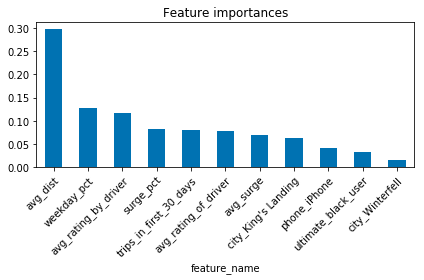

In [37]:
feature_importances = grid.best_estimator_.feature_importances_
pd.DataFrame({'feature_name': X.columns, 'feature_importance': feature_importances})\
        .sort_values('feature_importance', ascending=False)\
        .plot.bar('feature_name', legend=False)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Feature importances')
plt.tight_layout()
plt.show()

The feature importances generated by the random forest classifier are often not aligned with the coefficient magnitudes from logistic regression. In both models, 'avg_dist' appears to be an important feature, but the importance of other features are not significantly different from each other, hence the difference in rankings in different models.